In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
#Task 1 Read dataset and create data loaders
# Normalize the test data set
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Normalize the test data set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

#Retrieve the data set and making sure its shuffled for data argumentaion. Used batchsize 128 with 2 workers.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)


#Retrieve the data. Used batchsize 128 with 2 workers.
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print("Number of training images:", len(trainset))
print("Number of test images:", len(testset))

100%|██████████| 170M/170M [00:05<00:00, 33.7MB/s]


Number of training images: 50000
Number of test images: 10000


In [ ]:
#Task 2. Create the model
#Created the stem in a seperate class, 3 input channels and 48 output channels
#Used Batchnorm and relu
class Stem(nn.Module):
    def __init__(self, in_channels=3, out_channels=48):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

#Class for each block.
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, K, pool_flag=True, dropout_rate=0.1):
        super().__init__()
        self.K = K
        self.out_channels = out_channels
        self.pool_flag = pool_flag

        #Following the model description for the expert branch.
        reduction_ratio = 4
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels // reduction_ratio, K)
        self.softmax = nn.Softmax(1)

        #Create a Module List with K conv layers, each have dropout 0.1 bachnorm and relu.
        self.convs = nn.ModuleList()
        for i in range(K):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout2d(p=dropout_rate)
            )
            self.convs.append(conv_block)

        #Using Relu and dropout again.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        b, c, h, w = x.size()

        #Creating the tensor of a's through the expert branch
        gap = F.adaptive_avg_pool2d(x, (1, 1)).view(b, c)
        a = self.fc1(gap)
        a = self.relu(a)
        a = self.fc2(a)
        a = self.softmax(a)

        # a1 * conv1(x) +  a2 * conv2(x) + ... + aN * convN(x)
        out = 0
        for i in range(self.K):
            out = out + self.convs[i](x) * a[:, i].view(b, 1, 1, 1)

        out = self.dropout(out)

        if self.pool_flag:
            out = self.pool(out)

        return out

#Below is the creation of the backbone where i hardcoded the specs of the blocks
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()

        #Only the first block doesnt contain max pool and in/out channels can be seen
        self.block1 = Block(48, 64, 2, pool_flag=False)
        self.block2 = Block(64, 64, 3)
        self.block3 = Block(64, 128, 3)
        self.block4 = Block(128, 256, 4)
        self.block5 = Block(256, 512, 4)

    def forward(self, x):
        #Basic traversal of the blocks.
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x

#Creating the CIFARModel. Num classes and final_channels are 10 and 512.
class CIFARModel(nn.Module):
    def __init__(self, num_classes=10, final_channels=512):
        super().__init__()

        #First stem then backbone then classifier.
        self.stem = Stem()
        self.backbone = Backbone()
        self.classifier = nn.Linear(final_channels, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.backbone(x)

        #avg_pool2d and drop out of 0.5 is used within classifier.
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = F.dropout(x, p=0.5, training=self.training)

        logits = self.classifier(x)

        return logits

#Initiating the weights
def _init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

#Took inspiration from my_utils, Reference my_utils week3.

#Animator will output 2 different graphs, 1 for loss and 1 for acc.
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim_acc=None, ylim_loss=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), figsize=(7, 5)):
        # Initialize with two subplots
        if legend is None:
            legend = []

        plt.rcParams['figure.dpi'] = 100
        self.fig, (self.ax_acc, self.ax_loss) = plt.subplots(2, 1, figsize=figsize)

        # Configure the axes
        self.config_ax_acc = lambda: self.set_axes(
            self.ax_acc, xlabel, 'Accuracy', xlim, ylim_acc, xscale, yscale,
            ['train acc', 'test acc'])
        self.config_ax_loss = lambda: self.set_axes(
            self.ax_loss, xlabel, 'Loss', xlim, ylim_loss, xscale, yscale,
            ['train loss'])

        # Initialize data containers
        self.X, self.Y_acc, self.Y_loss = [], [[], []], [[]]
        self.fmts_acc = [fmts[1], fmts[2]]  # For train_acc and test_acc
        self.fmts_loss = [fmts[0]]  # For train_loss

        # Adjust layout
        self.fig.tight_layout(pad=2.0)

    def set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib."""
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        if legend:
            ax.legend(legend)
        ax.grid()

    def add(self, x, y):
        # y should be (loss, train_acc, test_acc)
        self.X.append(x)
        self.Y_loss[0].append(y[0])  # Loss
        self.Y_acc[0].append(y[1])   # Train acc
        self.Y_acc[1].append(y[2])   # Test acc

        # Clear and redraw accuracy plot
        self.ax_acc.cla()
        for i, (y, fmt) in enumerate(zip(self.Y_acc, self.fmts_acc)):
            self.ax_acc.plot(self.X, y, fmt)
        self.config_ax_acc()

        # Clear and redraw loss plot
        self.ax_loss.cla()
        for i, (y, fmt) in enumerate(zip(self.Y_loss, self.fmts_loss)):
            self.ax_loss.plot(self.X, y, fmt)
        self.config_ax_loss()

        # Update display
        self.fig.tight_layout()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
#Task 4 Write the training script to train the model.
def train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device, scheduler=None):
    #Move my model to the GPU
    model.to(device)

    #Set up the Animator
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                       ylim_acc=[0, 1.0], ylim_loss=[0, 2.0],
                       figsize=(10, 6))


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        #Training per batch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train / total_train

        model.eval()
        correct_test = 0
        total_test = 0

        #Check the accurace on the validation/test dataset
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        test_acc = correct_test / total_test

        #output message
        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.4f}  Test Acc: {test_acc:.4f}")

        animator.add(epoch + 1, (epoch_loss, epoch_acc, test_acc))

        #Early stoppage when both test and train acc is > 91% accuracy
        if epoch_acc > 0.91 and test_acc > 0.91:
            print(f"Early stopping at epoch {epoch+1} - Train Acc: {epoch_acc:.4f}, Test Acc: {test_acc:.4f}")
            break

        #sceduler step for LR adjustment
        if scheduler:
            scheduler.step()

    return

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CIFARModel()
model.apply(_init_weights)

#Task 3 Create the loss and optimizer
#The best loss functions for CNN's
loss_fn = nn.CrossEntropyLoss()

#Used SGD optimizer gabe me the best resutls for CNN's and 0.4 weight_decay to prevent overfitting.
#High learning rate 0.2 as it will be dropped by my scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9,  weight_decay=1e-4)

Early stopping at epoch 76 - Train Acc: 0.9130, Test Acc: 0.9128


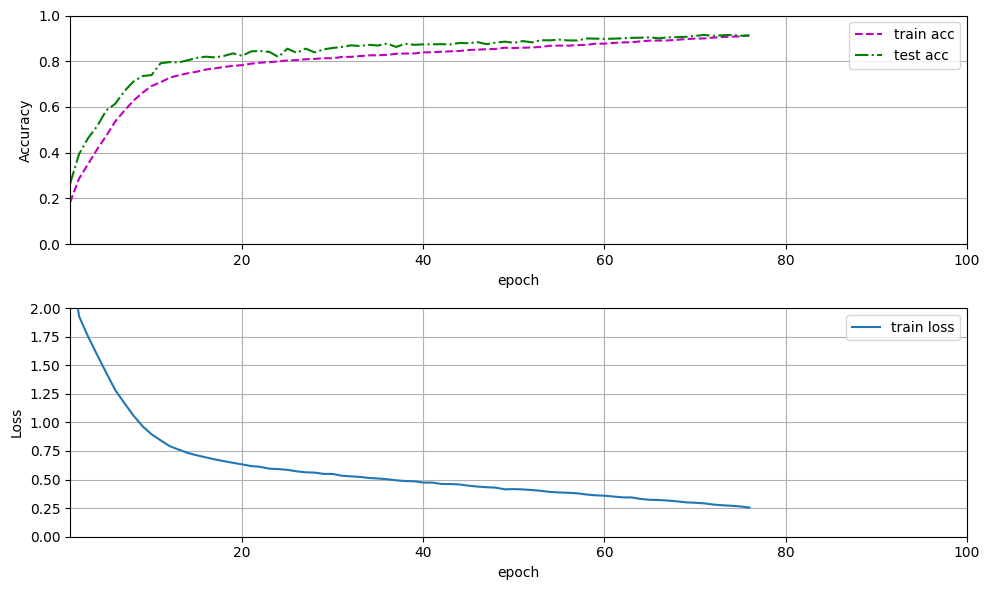

In [ ]:
#Task 5 Final model accuracy
#Run for 100 epochs however expected to hit early stoppage at 80
num_epochs = 100

#CosineAnnealingLR scheduler used to oppose the loss curve. It helped drop the lr in last half
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0005)


train_model(model, trainloader, testloader, loss_fn, optimizer, num_epochs, device, scheduler)